# Analysis of Bitcoin's Price Bubble History

Algorithmically detect phases of:
- uninterrupted market increases (drawups)
- uninterrupted market decreases (drawdowns)

![USD M2](https://d3fy651gv2fhd3.cloudfront.net/charts/united-states-money-supply-m2.png?s=unitedstamonsupm2&v=202105112315V20200908&d1=19210606)

In [1]:
import os
import requests

import pandas as pd
import numpy as np                    
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["axes.grid"] = True
pd.set_option('mode.chained_assignment', None)

In [2]:
filename = "bitstampUSD.csv.gz"

if not os.path.isfile(filename):
    # Try to download the bitstamp historical tick data file if you don't have it
    url = "https://api.bitcoincharts.com/v1/csv/bitstampUSD.csv.gz"
    r = requests.get(url, verify=False)  # issue with SSL cert
    
    with open(filename, 'wb') as f:
        f.write(r.content)
    

columns = ['ts','price', 'volume']
tick = pd.read_csv(filename, names=columns)
tick

,ts,price,volume
0,1315922016,5.80,1.00000
1,1315922024,5.83,3.00000
2,1315922029,5.90,1.00000
3,1315922034,6.00,20.00000
4,1315924373,5.95,12.45210
...,...,...,...
51508372,1620771429,56602.89,0.03929
51508373,1620771434,56602.89,0.00439
51508374,1620771434,56602.89,0.00157
51508375,1620771440,56602.89,0.00794


In [3]:
tick['time'] = pd.to_datetime(tick['ts'],unit='s')
tick.set_index('time', inplace=True)

In [4]:
df = tick['price'].resample('1D').median().to_frame()

<AxesSubplot:xlabel='time'>

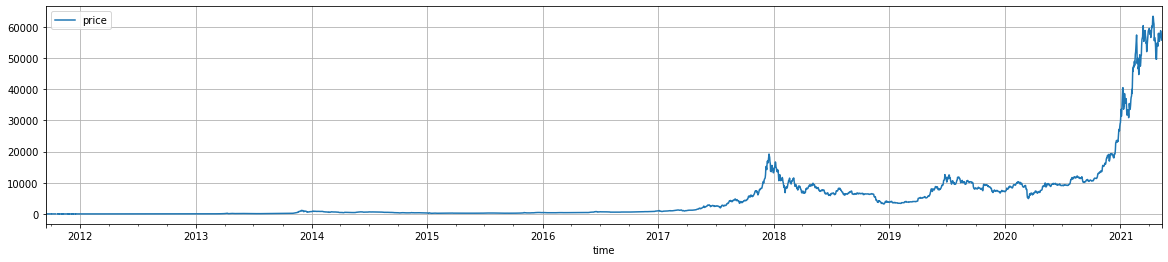

In [5]:
df.plot()

<AxesSubplot:xlabel='time'>

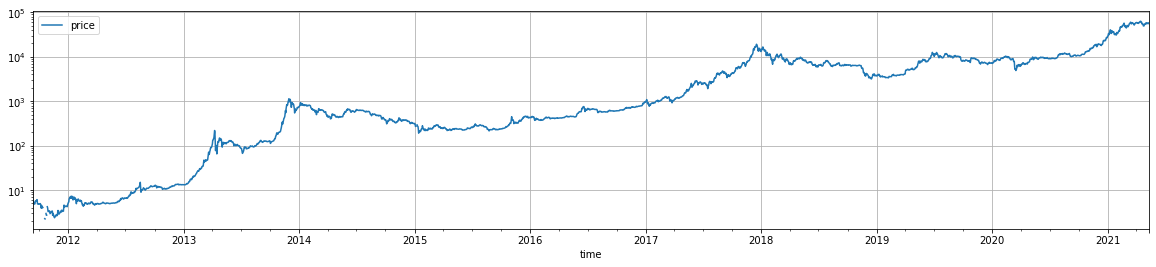

In [6]:
df.plot(logy=True)

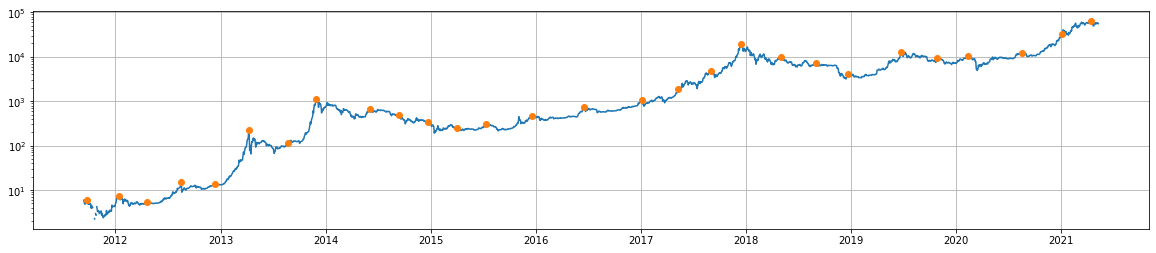

In [7]:
# Let's find and plot price peaks
peaks, _ = find_peaks(df['price'],  distance=100)
price_peaks = df.iloc[peaks]

plt.yscale('log')
plt.plot(df)
plt.plot(price_peaks, "o")
plt.show()

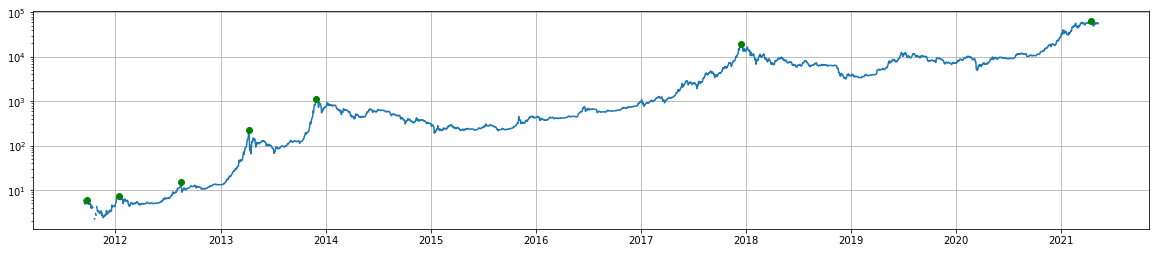

In [8]:
# There are too many price peaks, let's only filter the ones we care about
price_peaks['prev_peak'] = price_peaks['price'].rolling(9, min_periods=1).max()
price_peaks = price_peaks[price_peaks['price'] >= price_peaks['prev_peak']]
del(price_peaks['prev_peak'])

# manually clean up the data to remove some false positives
price_peaks.drop([price_peaks.index[8]], inplace=True)
price_peaks.drop([price_peaks.index[6]], inplace=True)
price_peaks.drop([price_peaks.index[5]], inplace=True)

plt.yscale('log')
plt.plot(df)
plt.plot(price_peaks, "go")
plt.show()

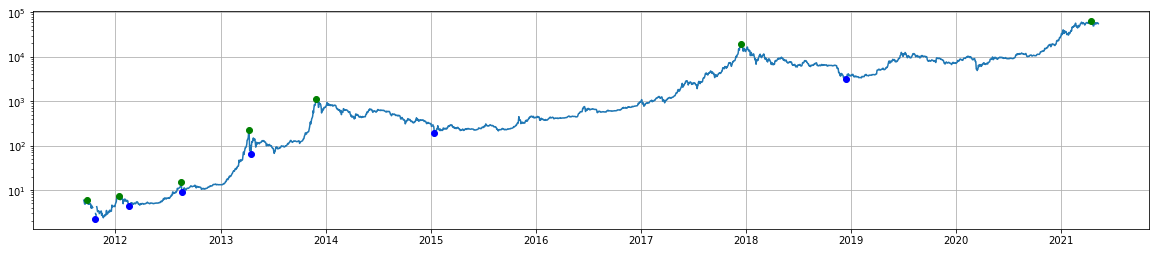

In [9]:
# Lets find the bottoms
price_bottoms_dates = []
price_peaks_dates = price_peaks.index
for i in range(len(price_peaks_dates) - 1):
    price_peak = price_peaks_dates[i]
    next_price_peak = price_peaks_dates[i + 1]
    data = df[price_peak:next_price_peak]
    price_bottoms_date = data.idxmin()
    price_bottoms_dates.append(price_bottoms_date[0])

price_bottoms = df.loc[price_bottoms_dates]

plt.yscale('log')
plt.plot(df)
plt.plot(price_peaks, "go")
plt.plot(price_bottoms, "bo")
plt.show()

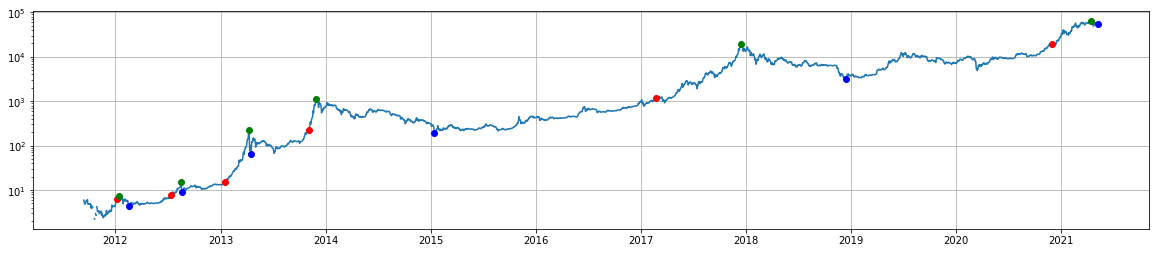

In [10]:
# Lets find the opens
price_open_dates = []
price_peaks_dates = price_peaks.index
for i in range(len(price_peaks_dates) - 1):
    price_peak = price_peaks_dates[i]
    next_price_peak = price_peaks_dates[i + 1]
    data = df[price_peak:next_price_peak]
    
    price_open_df = data[data['price'] > data['price'].iloc[0]]
    
    price_open_date = price_open_df.index[0]
    price_open_dates.append(price_open_date)
    
price_open_dates
price_opens = df.loc[price_open_dates]

# manual clean up to remove first high, remove first low, to show cycles
price_peaks = price_peaks[1:]
price_bottoms = price_bottoms[1:]

# because we don't have complete data of this 2021 cycle, we manually add a close using last available date
price_bottoms = pd.concat([price_bottoms, df[-1:]])

plt.yscale('log')
plt.plot(df)
plt.plot(price_opens, "ro")
plt.plot(price_peaks, "go")
plt.plot(price_bottoms, "bo")
plt.show()

In [11]:
cycles_data = []
for i in range(len(price_peaks)):
    cycle_data = {
        'open_date': price_opens.index[i],
        'open_price': price_opens.iloc[i].price,
        'high_date': price_peaks.index[i],
        'high_price': price_peaks.iloc[i].price,
        'close_date': price_bottoms.index[i],
        'close_price': price_bottoms.iloc[i].price,
    }
    cycles_data.append(cycle_data)
    
cycles = pd.DataFrame(cycles_data)
cycles

,open_date,open_price,high_date,high_price,close_date,close_price
0,2012-01-05,6.23,2012-01-12,7.25,2012-02-19,4.30
1,2012-07-13,7.60,2012-08-17,14.90,2012-08-19,8.90
2,2013-01-17,15.00,2013-04-09,219.00,2013-04-16,64.99
3,2013-11-04,221.26,2013-11-30,1136.68,2015-01-14,190.61
4,2017-02-23,1155.19,2017-12-17,19198.09,2018-12-15,3170.27
5,2020-11-30,19223.40,2021-04-14,63359.72,2021-05-11,55726.14


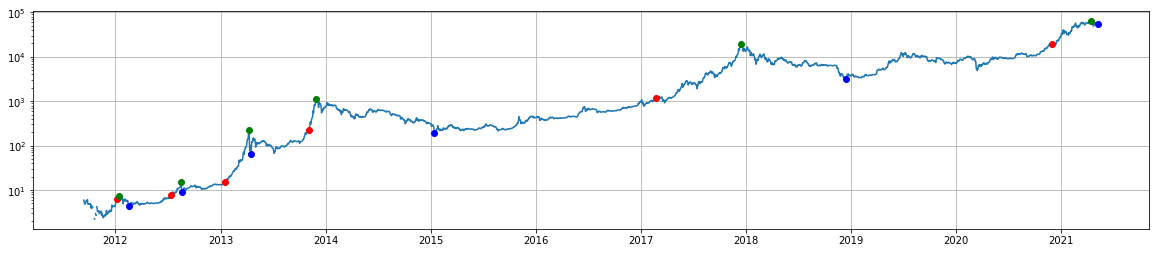

,open_date,open_price,high_date,high_price,close_date,close_price,open_high_days,high_close_days,high_open_ratio,close_high_ratio,close_open_ratio
0,2012-01-05,6.23,2012-01-12,7.25,2012-02-19,4.30,7 days,38 days,1.163724,0.593103,0.690209
1,2012-07-13,7.60,2012-08-17,14.90,2012-08-19,8.90,35 days,2 days,1.960526,0.597315,1.171053
2,2013-01-17,15.00,2013-04-09,219.00,2013-04-16,64.99,82 days,7 days,14.600000,0.296758,4.332667
3,2013-11-04,221.26,2013-11-30,1136.68,2015-01-14,190.61,26 days,410 days,5.137305,0.167690,0.861475
4,2017-02-23,1155.19,2017-12-17,19198.09,2018-12-15,3170.27,297 days,363 days,16.618989,0.165135,2.744371
5,2020-11-30,19223.40,2021-04-14,63359.72,2021-05-11,55726.14,135 days,27 days,3.295968,0.879520,2.898870


In [12]:
# Lets show the bubble stages and the bubble data
plt.yscale('log')
plt.plot(df)
plt.plot(price_opens, "ro")
plt.plot(price_peaks, "go")
plt.plot(price_bottoms, "bo")
plt.show()

cycles['open_high_days'] = cycles['high_date'] - cycles['open_date'] 
cycles['high_close_days'] = cycles['close_date'] - cycles['high_date']
cycles['high_open_ratio'] = cycles['high_price'] / cycles['open_price'] 
cycles['close_high_ratio'] = cycles['close_price'] / cycles['high_price']
cycles['close_open_ratio'] = cycles['close_price'] / cycles['open_price']
cycles

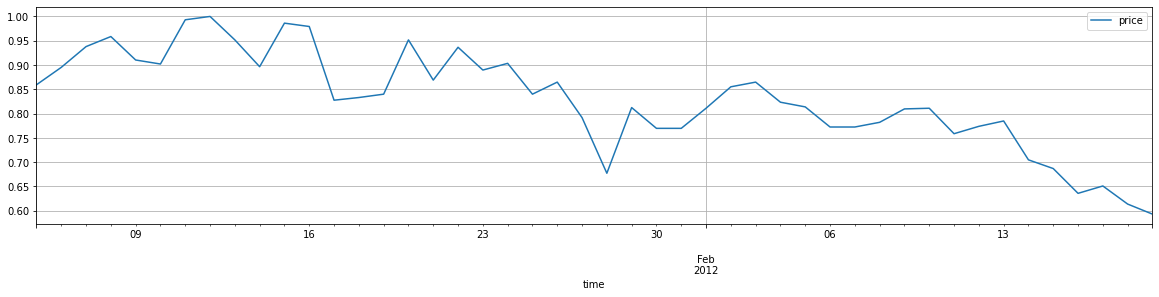

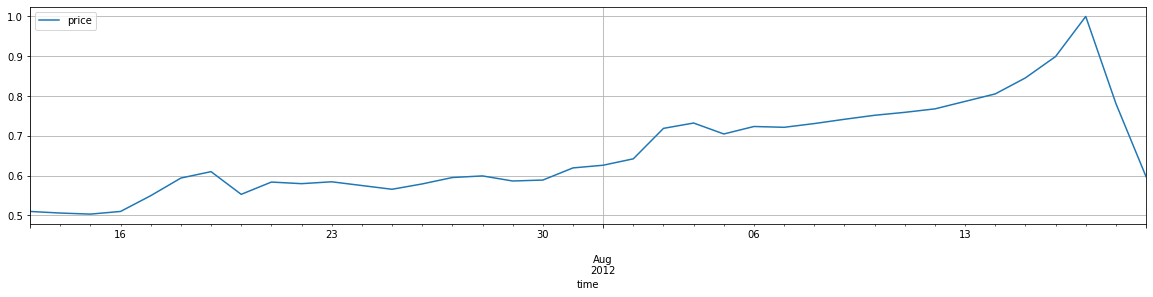

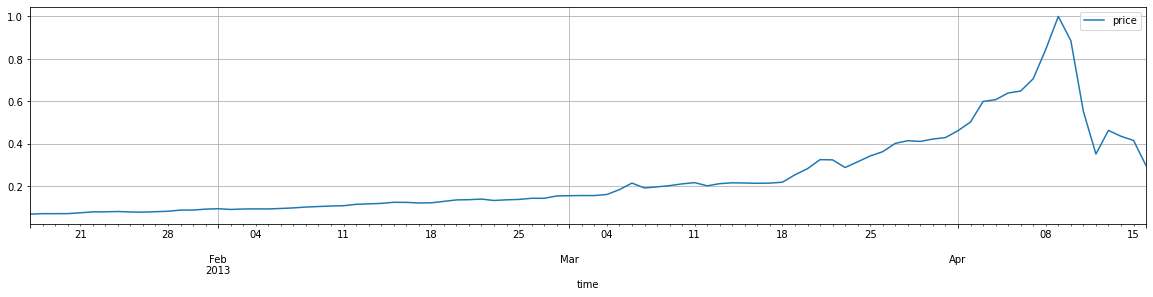

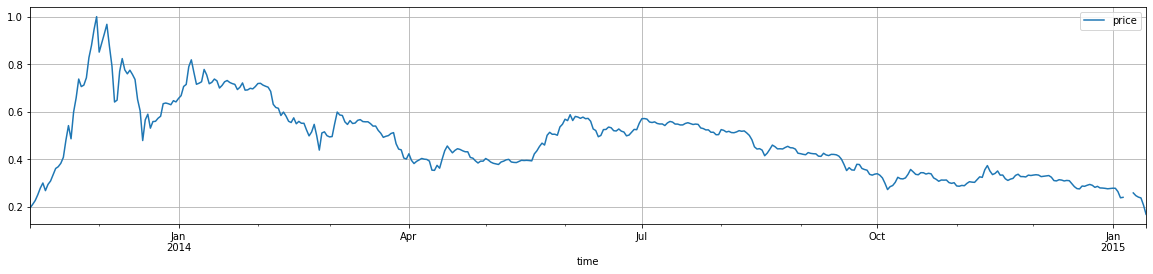

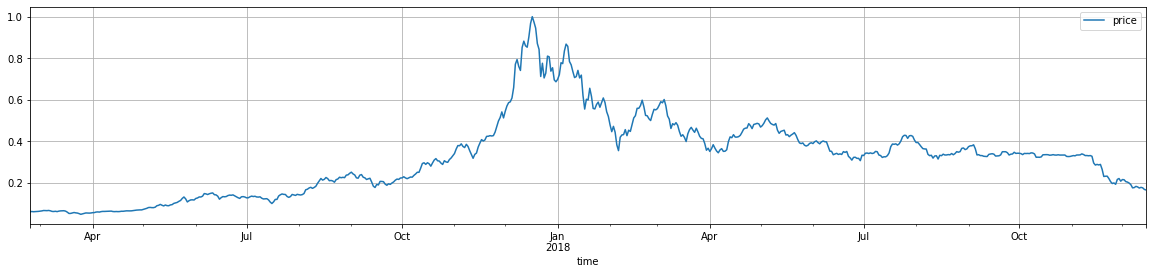

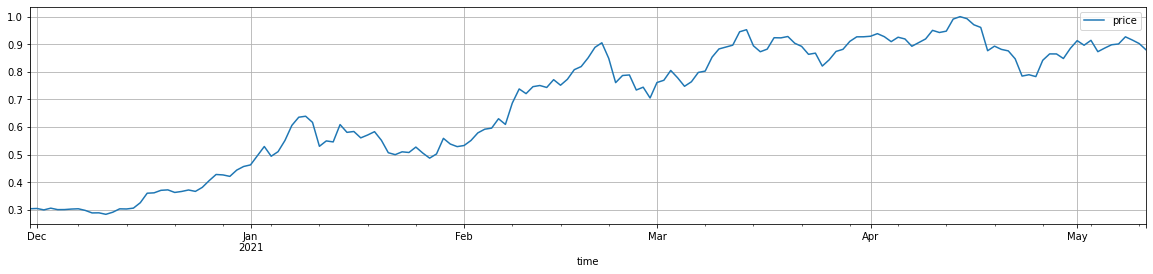

In [13]:
# Lets plot the 5 cycles (the 5th 2021 cycle is still incomplete)
for cycle in cycles.itertuples():
    (df[cycle.open_date:cycle.close_date]/cycle.high_price).plot()